In [1]:
from utils import *
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import pickle as pkl
from tqdm.notebook import tqdm

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24

USE_CACHE=True

In [2]:
# Blue to red color scheme
color_rgbs = [
[178,24,43],
 [239,138,98],
[253,219,199],
[33,102,172]
]

color_rgbs = [list((c / 256 for c in l)) for l in color_rgbs][::-1]
custom_map = ListedColormap(color_rgbs, name="custom")

#### Only run the following cell if you don't want to use the cached values and instead want to re-run the calculations.

In [3]:
params = {}

SIZE = int(1e3)

g = 9.8 # gravity
params["du"] = 1 # height upper
params["mu_u"] = 1e3 # visc upper
params["rho_l"] = 3000 #density lower
params["rho_u"] = 2970 #density upper
params["r"] = params["rho_l"] / params["rho_u"] #density ratio


dls = np.concatenate([np.linspace(.2, 1, SIZE // 2), np.linspace(1.01, 5, SIZE // 2)]) # range of height lowers

Kus = np.logspace(2, 6, SIZE) 

Ups = Kus * (params["du"] ** 2) / params["mu_u"]

Fs = np.sqrt((params["rho_l"]-params["rho_u"]) / \
                              params["rho_u"] * g * params["du"] / (Ups ** 2))


d2d2, ff = np.meshgrid(dls, Fs)
z = np.zeros((len(dls), len(Fs))).T

# for viscosity range
for idx, m in enumerate([.85, .9, .95]):
    params["m"] = m
    params["mu_l"] = params["mu_u"] * m
    # for k range
    for y_idx, (Ku_p, U_p, F) in enumerate(tqdm(zip(Kus, Ups, Fs), total=SIZE)):
        params["Ku_p"] = Ku_p
        params["U_p"] = U_p
        params["F"] = F
        
        # for height range
        for x_idx, n in enumerate(dls):
            params["dl"] = params["du"] * n
            params["n"] = n
            gamma = n ** 3 * params["r"] / params["m"] ** 2;
            params["Kl_p"] = params["Ku_p"] / gamma

            J = free_surface_J(**params)
            z[y_idx, x_idx] += int(J > 0)   


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
if USE_CACHE and os.path.exists("cached_matrices"):
    try:
        d2d2 = np.load("cached_matrices/free_surface_d2d2.npy", allow_pickle=True)
    except FileNotFoundError:
        print("Run the previous cell or pull from the github repo to get d2d2 data.")
        
    try:
        ff = np.load("cached_matrices/free_surface_ff.npy", allow_pickle=True)
    except FileNotFoundError:
        print("Run the previous cell or pull from the github repo to get ff data.")
        
    try:
        z = np.load("cached_matrices/free_surface_z.npy", allow_pickle=True)
    except FileNotFoundError:
        print("Run the previous cell or pull from the github repo to get z data.")

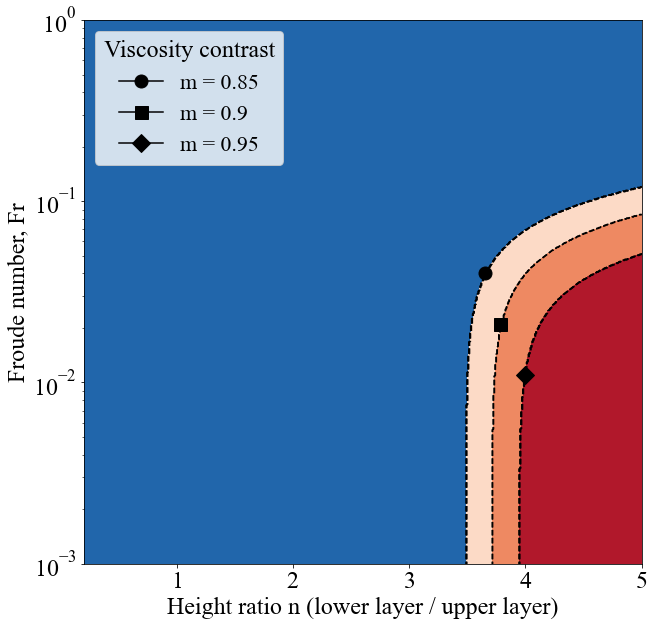

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
ax.contourf(d2d2, ff, z, cmap=custom_map)
ax.contour(d2d2, ff, z, colors="black", linestyles="--")

MARKER_SIZE = 13

m1_line = mlines.Line2D([], [], color='black', label='m = 0.85', marker="o", markersize=MARKER_SIZE)
m2_line = mlines.Line2D([], [], color='black', label='m = 0.9', marker="s", markersize=MARKER_SIZE)
m3_line = mlines.Line2D([], [], color='black', label='m = 0.95', marker="D", markersize=MARKER_SIZE)

ax.plot(3.65, .04, 'o', markersize=MARKER_SIZE, color="black")
ax.plot(3.78, .021, 's', markersize=MARKER_SIZE, color="black")
ax.plot(4.0, 0.011, 'D', markersize=MARKER_SIZE, color="black")


ax.set_ylabel("Froude number, Fr")
ax.set_xlabel("Height ratio n (lower layer / upper layer)")

plt.legend(handles=[m1_line, m2_line, m3_line], \
           loc="upper left", fontsize=22, title="Viscosity contrast")

ax.set_yscale('log')
ax.set_ylim(1e-3, 1)

if not os.path.exists("paper_figures"):
    os.mkdir("paper_figures")

fig.savefig("paper_figures/free_surface_phase.png")
fig.savefig("paper_figures/free_surface_phase.svg", format="svg")

In [6]:
if not os.path.exists("cached_matrices"):
    os.mkdir("cached_matrices")
    
np.save("cached_matrices/free_surface_d2d2.npy", d2d2, allow_pickle=True)
np.save("cached_matrices/free_surface_ff.npy", ff, allow_pickle=True)
np.save("cached_matrices/free_surface_z.npy", z, allow_pickle=True)